In [1]:
import sys
f = open('log2.txt', 'w')
sys.stdout = f

### train

#### imports and constants

In [1]:
import random
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
seed_val = 42
device = "cuda:0"
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [3]:
data_path = "data/mnli2/mnli"

#### read data

In [4]:
df = pd.read_csv(data_path+"_train_clean.csv")
df_train, df_validation = train_test_split(df, test_size=0.1, random_state=42)

In [5]:
df_test = pd.read_csv(data_path+"_test_clean.csv")

In [6]:
df_train = df_train.head(1000)
df_validation = df_validation.head(1000)
df_test = df_test.head(1000)

In [7]:
# used for 2 text tasks like NLI
if "content2" in df_train.columns:
    df_train["content"] = list(zip(df_train.content, df_train.content2))
    df_train = df_train.drop("content2", 1)
    df_validation["content"] = list(zip(df_validation.content, df_validation.content2))
    df_validation = df_validation.drop("content2", 1)
    df_test["content"] = list(zip(df_test.content, df_test.content2))
    df_test = df_test.drop("content2", 1)

In [8]:
# Get the lists of sentences and their labels.
sentences_train = df_train.content.values
labels_train = df_train.label.values

sentences_validation = df_validation.content.values
labels_validation = df_validation.label.values

sentences_test = df_test.content.values
labels_test = df_test.label.values

#### tokenising & formatting data

In [9]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/home/gallilm/.conda/envs/gallilm2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gallilm/.conda/envs/gallilm2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gallilm/.conda/envs/gallilm2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gallilm/.conda/envs/gallilm2/lib/python3

Loading BERT tokenizer...


In [10]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_train = []

# For every sentence in train
for sent in sentences_train:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        *sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded sentence to the list.
    input_ids_train.append(encoded_sent)
print("Train done!")
    
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_validation = []

# For every sentence in test
for sent in sentences_validation:
    encoded_sent = tokenizer.encode(
                        *sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded sentence to the list.
    input_ids_validation.append(encoded_sent)
print("Validation done!")
    
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_test = []

# For every sentence in test
for sent in sentences_test:
    encoded_sent = tokenizer.encode(
                        *sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded sentence to the list.
    input_ids_test.append(encoded_sent)
print("Test done!")

Train done!
Validation done!
Test done!


In [11]:
def pad_sequences(input_ids, maxlen):
    padded = []
    for inp in input_ids:
        if len(inp) >= maxlen:
            padded.append(inp[:maxlen-1] + [inp[-1]])
        else:
            padded.append(inp + [0]*(maxlen - len(inp)))
    return padded

#### histogram of length for choosing the length

In [12]:
import matplotlib.pyplot as plt

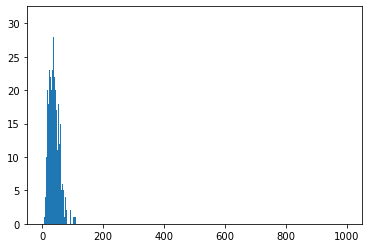

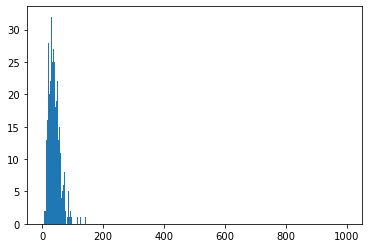

In [13]:
lens_train = [len(inp) for inp in  input_ids_train]
plt.hist(lens_train, bins=1000, range=(0,1000))
plt.show()
lens_validation = [len(inp) for inp in  input_ids_validation]
plt.hist(lens_validation, bins=1000, range=(0,1000))
plt.show()

In [14]:
print((np.array(lens_train)<=256).sum()/ len(lens_train))

1.0


In [15]:
# Set the maximum sequence length.
MAX_LEN = 256

print('Padding/truncating all sentences to %d values...' % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN)
input_ids_validation = pad_sequences(input_ids_validation, maxlen=MAX_LEN)
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN)

print('Done.')

Padding/truncating all sentences to 256 values...
Padding token: "[PAD]", ID: 0
Done.


In [16]:
# Create attention masks
attention_masks_train = []

# For each sentence...
for sent in input_ids_train:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks_train.append(att_mask)
    
# Create attention masks
attention_masks_validation = []

# For each sentence...
for sent in input_ids_validation:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks_validation.append(att_mask)

    
attention_masks_test = []

# For each sentence...
for sent in input_ids_test:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks_test.append(att_mask)

In [17]:
# rename
train_inputs, validation_inputs, test_inputs, train_labels, validation_labels, test_labels = input_ids_train, input_ids_validation, input_ids_test, labels_train, labels_validation, labels_test
train_masks, validation_masks, test_masks = attention_masks_train, attention_masks_validation, attention_masks_test

### create dataset & dataloader

In [18]:
# Convert all inputs and labels into torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [20]:
train_inputs.shape

torch.Size([1000, 256])

### model & optimiser & scheduler

In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [22]:
NUM_LABELS = 3  # 3 for MNLI, 2 for IMDB, Toxic-WIKI, PUBMED

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = NUM_LABELS,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [23]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [24]:
from transformers import get_linear_schedule_with_warmup

epochs = 4  # 2 for text classification, 4 for MNLI 
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, 
                                            num_training_steps=total_steps)

### train loop

In [25]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return (pred_flat == labels_flat).mean()

In [26]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
# evaluation only - to make sure that accuracy is more or less random at the beginnig
print("")
print("Running Validation...")
device = "cuda"
t0 = time.time()

model.eval()

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():        
        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))



Running Validation...
  Accuracy: 0.32
  Validation took: 0:00:08


In [28]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    print()
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 200 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull theloss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 - This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        

            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.11
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.4008
  Validation took: 0:00:08

======== Epoch 2 / 4 ========
Training...

  Average training loss: 1.01
  Training epcoh took: 0:00:25

Running Validation...
  Accuracy: 0.5069
  Validation took: 0:00:08

======== Epoch 3 / 4 ========
Training...


KeyboardInterrupt: 

### saving

In [ ]:
torch.save(model.state_dict(), open(data_path+"_bert.pth", 'wb'))

In [ ]:
f.close()

# inference example

In [ ]:
# with a saved model & cpu - Load a trained model that you have fine-tuned
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
model_loaded = BertForSequenceClassification.from_pretrained("bert-base-uncased", state_dict=torch.load(data_path+"_bert.pth"), num_labels=NUM_LABELS)

In [25]:
# %%timeit
text = ('it was tedious movie at times but altogether i would recommend it', 'the movie is unrecommended')
model_loaded.eval()
with torch.no_grad():
    if type(text) == tuple:
        sent_token = torch.Tensor(pad_sequences([tokenizer.encode(*text, add_special_tokens=True)], 128)).long()
    else:
        sent_token = torch.Tensor(pad_sequences([tokenizer.encode(text, add_special_tokens=True)], 128)).long()
    sent_att = (sent_token > 0).int()
    res = model_loaded(sent_token, attention_mask=sent_att)

In [26]:
res

(tensor([[-2.2395, -1.3262,  4.2226]]),)

## infer on test

In [4]:
base_path = 'data/mnli2/mnli'
model_path = base_path + '_bert.pth'
tst_path = base_path + '_test_clean.csv'
out_path = base_path + '_test_pred_bert.csv'

In [68]:
NUM_LABELS = 3
model_loaded = BertForSequenceClassification.from_pretrained("bert-base-uncased", state_dict=torch.load(model_path), num_labels=NUM_LABELS)
model_loaded.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [15]:
# read the dataset
tst_df = pd.read_csv(tst_path)

In [70]:
import torch.nn.functional as F

In [71]:
import time
import datetime

In [72]:
pred_list = []
proba_list = []
raw_out = []
# evaluation only
print("")
print("Running Test...")
device = "cuda"
t0 = time.time()

model_loaded.eval()

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in test_dataloader:

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():        
        # Forward pass, calculate logit predictions.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model_loaded(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # Get the "logits" output by the model
    logits = outputs[0]
    
    raw_out.append(logits.cpu().numpy())
    
    probs, preds = F.softmax(logits).max(1)
    
    pred_list.append(preds.cpu().numpy())
    proba_list.append(probs.cpu().numpy())
    
tst_df['preds'] = np.concatenate(pred_list)


Running Test...


/home/gallilm/.conda/envs/gallilm2/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


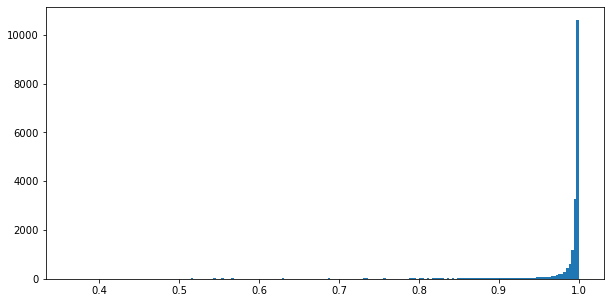

In [73]:
import matplotlib.pyplot as plt
# look at distibution of probabilities
plt.figure(figsize=(10, 5))
plt.hist(np.concatenate(proba_list), bins=200)
plt.show()

In [16]:
tst_df["preds"] = np.concatenate(code_preds).argmax(1)

In [17]:
# make sure of accuracy and no mistakes
(tst_df['preds']==tst_df['label']).mean()

0.8372

In [18]:
# save result
tst_df.to_csv(out_path, index=False)

### infernce with other code

In [5]:
import src.TextModels.Bert as Bert

/home/gallilm/.conda/envs/gallilm2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gallilm/.conda/envs/gallilm2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gallilm/.conda/envs/gallilm2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gallilm/.conda/envs/gallilm2/lib/python3

In [51]:
from importlib import reload
reload(Bert)

<module 'src.TextModels.E2EBert' from '/home/gallil/Desktop/projects/LUNATC/src/TextModels/E2EBert.py'>

In [7]:
# used for 2 text tasks like NLI
if "content2" in tst_df.columns:
    tst_df["content"] = list(zip(tst_df.content, tst_df.content2))
    tst_df = tst_df.drop("content2", 1)

In [8]:
code_model = Bert.BertTextModel(num_classes=3, trained_model=model_path)

In [ ]:
# %%timeit
code_model.predict_proba(32*['amazing film !'])

In [9]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield ndx, iterable[ndx:min(ndx + n, l)]

In [58]:
# code_preds = []
# for i, text in enumerate(tst_df.content):
#     print(f'\r{i/len(tst_df)}', end='')
#     code_preds.append(code_model.predict_proba(text))

In [10]:
code_preds = []
for i, text in batch(tst_df.content.values.tolist(), 64):
    print(f'\r{i/len(tst_df)}', end='')
    if type(text[0]) == tuple:
        text = tuple(zip(*text))
    code_preds.append(code_model.predict_proba(text))

0.9984

In [47]:
(np.abs((np.concatenate(code_preds) - np.concatenate(raw_out))) > 0.0001).any()

False

In [11]:
(np.concatenate(code_preds).argmax(1) == tst_df.label).mean()

0.8372

In [12]:
tst_df

,content,label
0,"(on the basis of engineering estimates , the e...",1
1,"(tuppence was first at the rendezvous ., no on...",0
2,(the discount shopping centers here rival thos...,2
3,(right inexperience also that's something that...,0
4,"(we shall be pinched at first , of course , be...",1
...,...,...
99986,"(do you watch that ?, can you see ?)",2
99987,"(to a western ear , the most predictable of la...",2
99988,(the recorder captured the sounds of loud thum...,2
99989,"(that's a good attitude !, you feel good about...",1


In [53]:
(np.concatenate(code_preds).argmax(1) == tst_df.label).mean()

0.8368707690741589

In [64]:
(np.concatenate(code_preds).argmax(1) == tst_df.label).mean()

0.8348857331908179